# Занятие 5
# Прикладная алгебра и численные методы
## Интерполяция: полиномы Лагранжа, сплайны и кривые Безье

In [3]:
import numpy as np
import scipy.linalg
import sympy
from sympy import S, latex, Eq
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import interp1d, splrep, splev, InterpolatedUnivariateSpline, BPoly, CubicSpline
%matplotlib inline

In [176]:
import sympy
import numpy
sympy.__version__, numpy.__version__

('1.9', '1.19.0')

In [177]:
!python -m pip install sympy --upgrade
!python -m pip install -U matplotlib
!pip install numpy==1.19.0

In [178]:
import sympy
import numpy
sympy.__version__, numpy.__version__

('1.9', '1.19.0')

In [179]:
#sympy.init_printing(use_unicode=False, wrap_line=False, no_global=True)

## Многочлен Лагранжа
$$
f(x) = L(x) = \sum_{i=1}^n y_i 
\frac{(x - x_0)(x - x_1)...(x - x_{i-1})(x - x_{i+1})...(x - x_n)}{(x_i - x_0)(x_i - x_1)...(x_i - x_{i-1})(x_i - x_{i+1})...(x_i - x_n)}, 
\quad y_i = f(x_i), \quad i = 0, ..., n.
$$
## Задача 1
Приблизить параболой косинус на отрезке от $-\frac{\pi}{4}$ до $\frac{\pi}{4}$, выбрать промежуточную точку на середине отрезка.

In [180]:
x = S('x')
X = (-sympy.pi/4, 0, sympy.pi/4)
Y = [sympy.cos(elem) for elem in X]
L = 0
for i in range(3):
    Li = Y[i]
    for j in range(3):
        if i != j:
            Li *= (x - X[j]) / (X[i] - X[j])
    L += Li
display(L, sympy.simplify(sympy.expand(L))) 

4*sqrt(2)*x*(x - pi/4)/pi**2 + 4*sqrt(2)*x*(x + pi/4)/pi**2 - 16*(x - pi/4)*(x + pi/4)/pi**2

(-16*x**2 + 8*sqrt(2)*x**2 + pi**2)/pi**2

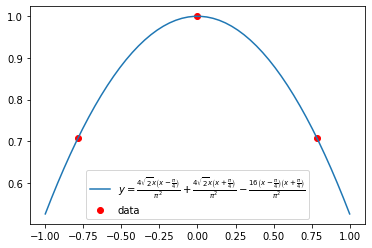

In [181]:
grX = np.linspace(-1, 1)
grY = [L.subs(x, elem) for elem in grX]
plt.plot(grX, grY, label =f"${sympy.latex(sympy.Eq(S('y'), L))}$")
plt.scatter(X, Y, color = 'red', label = 'data')
plt.legend()

## Задача 2 Линейная регрессия
Для косинуса построить параболу методом линейной регрессии
на отрезке от $-\frac{\pi}{4}$ до $\frac{\pi}{4}$, выбрать 10 промежуточных точек равномерно распределенных на отрезке. 
Изобразить на графике точки косинуса и полученную параболу.

In [182]:
X2 = [-np.pi/4, 0, np.pi/4]
A2 = np.array([[1, item, item ** 2] for item in X2])
Y2 = np.array([[np.cos(elem)] for elem in X2])
res2 = np.linalg.pinv(A2) @ Y2
a2, b2, c2 = [round(item, 2) for item in  res2[:, 0]]
display('A', A2,'Y', Y)
print('a =', a2, 'b =', b2, 'c =', c2)

'A'

array([[ 1.        , -0.78539816,  0.61685028],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.78539816,  0.61685028]])

'Y'

[sqrt(2)/2, 1, sqrt(2)/2]

a = 1.0 b = -0.0 c = -0.47


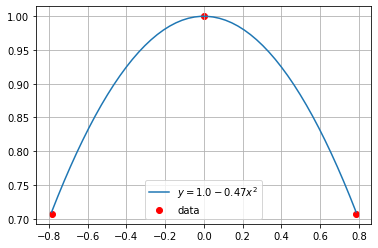

In [183]:
from sympy.abc import x, y
a, b, c = [num for num in (a2, b2, c2)]
X_ls2 = np.linspace(X2[0], X2[-1])
plt.plot(X_ls2, a2 + b2 * X_ls2 + c2 * X_ls2 ** 2,
         label=latex(Eq(y, a + b*x + c * x ** 2), mode='inline')
         )
plt.scatter(X2, Y2, color='red', label='data')
plt.grid()
plt.legend()

## Задача 3
Построить по определению и с помощью scipy.interpolate.lagrange полином Лагранжа для косинуса 
на отрезке от $-\frac{\pi}{4}$ до $\frac{\pi}{4}$, выбрать 3 промежуточных точки равномерно распределенных на отрезке. 
Изобразить на графике точки косинуса и полиномы Лагранжа.

In [184]:
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [185]:
poly = lagrange(X2, Y2)
coeffs = Polynomial(poly).coef
coeffs

array([-0.4748206,  0.       ,  1.       ])

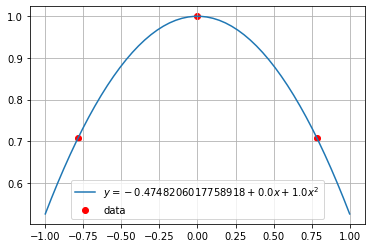

In [186]:
grYLag = [coeffs[0] * elem**2 + coeffs[1] * elem + coeffs[2] for elem in grX]
plt.plot(grX, grYLag, label='$y = {a} + {b}x + {c}x^2$'.format(a=coeffs[0],
                                                  b=coeffs[1], c=coeffs[2]))
plt.scatter(X2, Y2, color='red', label='data')
plt.grid()
plt.legend()

## Сплайны

## Задача 4
Аппроксимировать $f(x) = \tan(x^2)$ на отрезке $[-0.75, 0.75]$ квадратичным и кубическим сплайном с узлами на концах и в трех равномерно распределенных промежуточных точках. 

Построить на графике исходную функцию и сплайны.

In [230]:
# Kuadro spline auxiliary functions
a0, a1, a2, x = sympy.symbols('a0:3 x')

def spl2(a0, a1, a2, x):
    return a0 + a1 * x + a2 * x ** 2
def dspl2(a0, a1, a2, x, x0):
    return spl2(a0, a1, a2, x).diff(x).subs(x, x0)
def f(x):
    return sympy.tan(x ** 2)
def df(x, x0):
    return f(x).diff(x).subs(x, x0)
def sys(df0, f0, f1, x0, x1):
    return [sympy.Eq(dspl2(a0, a1, a2, x, x0), df0),
           sympy.Eq(spl2(a0, a1, a2, x0), f0),
           sympy.Eq(spl2(a0, a1, a2, x1), f1),
           ]


In [236]:
def kuadroSpline(X):
  X.sort()
  F = [f(xi) for xi in X]
  A = sympy.symbols('a0:3')

  df0 = f(x).diff(x).subs(x, X[0])
  dF = [df0]
  splines = []
  for i in range(len(X) - 1):
    syst = sys(dF[i], F[i], F[i+1], X[i], X[i+1])
    res = sympy.solve(syst)
    spline = res[A[0]] + res[A[1]]*x + res[A[2]]*x**2
    df = spline.diff(x).subs(x, X[i+1])
    dF.append(df)
    splines.append(spline)
  
  X_ls = [np.linspace(X[i], X[i+1]) for i in range(len(X) - 1)]
  Y = [[splines[i].subs(x, item) for item in X_ls[i]] for i in range(len(X) - 1)]
  X_lsF = np.linspace(X[0], X[-1])
  FX = [f(elem) for elem in X_lsF]
  for i in range (len(X) - 1):
    plt.plot(X_ls[i], Y[i])
  plt.plot(X_lsF, FX, 'c--')
  plt.scatter(X, [f(elem) for elem in X])


In [232]:
# Cube spline auxiliary functions
a0, a1, a2, a3, x = sympy.symbols('a0:4 x')

def spl3(a0, a1, a2, a3, x):
    return a0 + a1 * x + a2 * x ** 2 + a3 * x ** 3

def dspl3(a1, a2, a3, x):
    return a1 + 2 * a2 * x + 3 * a3 * x ** 2

def d2spl3(a2, a3, x):
    return 2 * a2 + 6 * a3 * x

def sys_spl(xi, xi_1, yi, yi_1, d1spl, d2spl):
    return [sympy.Eq(spl3(a0, a1, a2, a3, xi_1), yi_1),
            sympy.Eq(spl3(a0, a1, a2, a3, xi), yi),
            sympy.Eq(dspl3(a1, a2, a3, xi_1), d1spl),
            sympy.Eq(d2spl3(a2, a3, xi_1), d2spl)]

def fx(x, lib='sympy'):
    if lib == 'sympy':
        return sympy.sin(x)
    if lib == 'numpy':
        return np.sin(x)

In [235]:
def cubeSpline(X):
  X.sort()
  F = [f(xi) for xi in X]
  A = sympy.symbols('a0:4')

  df0_1 = f(x).diff(x).subs(x, X[0])
  df0_2 = f(x).diff(x, 2).subs(x, X[0])
  dF_1 = [df0_1]
  dF_2 = [df0_2]
  splines = []
  for i in range(len(X) - 1):
    syst = sys_spl(X[i+1], X[i], F[i+1], F[i], dF_1[i], dF_2[i])
    res = sympy.solve(syst)
    spline = res[A[0]] + res[A[1]] * x + res[A[2]] * x ** 2 + res[A[3]] * x ** 3
    df_1 = spline.diff(x).subs(x, X[i+1])
    df_2 = spline.diff(x, 2).subs(x, X[i+1])
    dF_1.append(df_1)
    dF_2.append(df_2)
    splines.append(spline)
  
  X_ls = [np.linspace(X[i], X[i+1]) for i in range(len(X) - 1)]
  Y = [[splines[i].subs(x, item) for item in X_ls[i]] for i in range(len(X) - 1)]
  X_lsF = np.linspace(X[0], X[-1])
  FX = [f(elem) for elem in X_lsF]
  for i in range (len(X) - 1):
    plt.plot(X_ls[i], Y[i])
  plt.plot(X_lsF, FX, 'c--')
  plt.scatter(X, [f(elem) for elem in X])


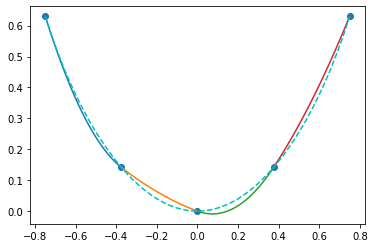

In [237]:
X = [-0.75, -0.75/2, 0, 0.75/2, 0.75]
kuadroSpline(X)

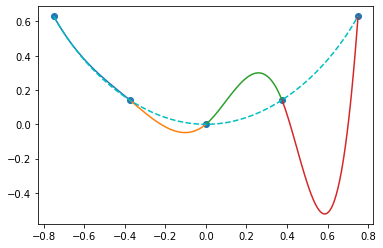

In [238]:
cubeSpline(X)

## Сплайны scipy.interpolate: interp1d, splrep, InterpolatedUnivariateSpline
https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate
#### Кубический сплайн:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline
####  interp1d
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
####  Полиномы Бернштейна
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BPoly.html#scipy.interpolate.BPoly

Теперь будем строить сплайны средствами scipy.interpolate, вначале подключим необходимые функции:

## interp1d
Параметры $x$ и  $y$ - координаты узлов сплайна, 
kind - str или int, необязательный параметр, определяющий тип сплайна, по умолчанию линейный (‘linear’), можно сделать ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’ или ‘next’. 

‘zero’, ‘slinear’, ‘quadratic’ и ‘cubic’ обозначают интерполяцию нулевого, первого, второго или третьего порядка,

‘previous’ и ‘next’ просто возвращают предыдущее или следующее значение функции

‘nearest-up’ и ‘nearest’ различаются обработкой полуцелых чисел, таких как 0.5, 1.5.


## Кривые Безье
#### Линейная кривая Безье
$P_0$ и $P_1$ две различные точки, тогда линейная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = P_0 + t(P_1 - P_0) = (1 - t)P_0 + tP_1,\quad 1\le t \le 1 
$$
#### Квадратичная кривая Безье
$P_0$, $P_1$ и $P_2$ три различные точки, тогда квадратичная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = (1 - t)^2P_0 + 2(1 - t)tP_1 + t^2P_2 = P_1 + (1 - t)^2(P_0 - P_1) + t^2(P_2 - P_1),\quad 1\le t \le 1 
$$
#### Кубическая кривая Безье
$P_0$, $P_1$, $P_2$ и $P_3$ четыре различные точки, тогда кубическая кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = (1 - t)^3P_0 + 3(1 - t)^2tP_1 + 3(1 - t)t^2P_2 +t^3P_3,\quad 1\le t \le 1 
$$
#### Общий вид кривой Безье
$P_0$, $P_1$, ...  и $P_n$ - $n$ различных точек, тогда линейная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = \sum_{k=0}^n C_n^k(1 - t)^{n - k}t^kP_k,\quad 1\le t \le 1 
$$

https://bezier.readthedocs.io/en/stable/python/reference/bezier.curve.html

## Задача 5
Построить кривую Безье по пяти равномерно распределенным точкам на графике $\sin x^2$ на отрезке  $\left[\frac{-\pi}{6}, \frac{\pi}{2}\right]$.

Для каждой точки построим полином Бернштейна $C_n^k(1 - t)^{n - k}t^k$, $1\le t \le 1$ и составим сумму произведений соответствующих координат точки на полиномы  Бернштейна.

In [7]:
from scipy.special import comb
def my_B(X, Y):
    n = len(X)
    def my_B_x(t):
        return sum([X[k] * comb(n - 1, k) * (1 - t) ** (n - k - 1) * t ** k for k in range(n)])
    def my_B_y(t):
        return sum([Y[k] * comb(n - 1, k) * (1 - t) ** (n - k - 1) * t ** k for k in range(n)])
    return (my_B_x, my_B_y)

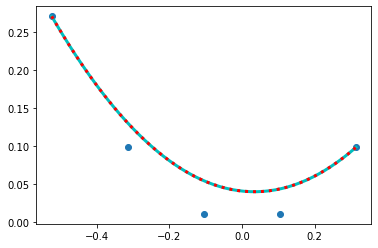

In [8]:
k = (np.pi/2 - np.pi/6) / 5
X = [-np.pi/6 + k * i for i in range(5)]
Y = [np.sin(elem*elem) for elem in X]

B_x, B_y = my_B(X, Y)
X1 = np.array(X).reshape(5, 1)
Y1 = np.array(Y).reshape(5, 1)
x = [0, 1]
bpX = BPoly(X1, x)
bpY = BPoly(Y1, x)
t_linspace = np.linspace(0, 1)
plt.plot(bpX(t_linspace), bpY(t_linspace), 'c-', B_x(t_linspace), B_y(t_linspace), 'r:', lw=3)
plt.scatter(X, Y)

## Задача 6
Построить кривую Безье Задачи 5 с помощью модуля bezier:

https://bezier.readthedocs.io/en/stable/python/reference/bezier.curve.html

In [245]:
!pip install bezier #--user

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 308 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.0
    Uninstalling numpy-1.19.0:
      Successfully uninstalled numpy-1.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [9]:
import bezier

In [11]:
nodes = np.array([X, Y])
curve = bezier.Curve(nodes, degree=4)
curve

<Curve (degree=4, dimension=2)>

In [12]:
curve.evaluate(0.75)

array([[0.10471976],
       [0.04379322]])

<AxesSubplot:>

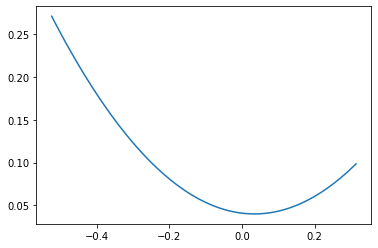

In [13]:
curve.plot(100)